/software/anaconda3/envs/scical/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


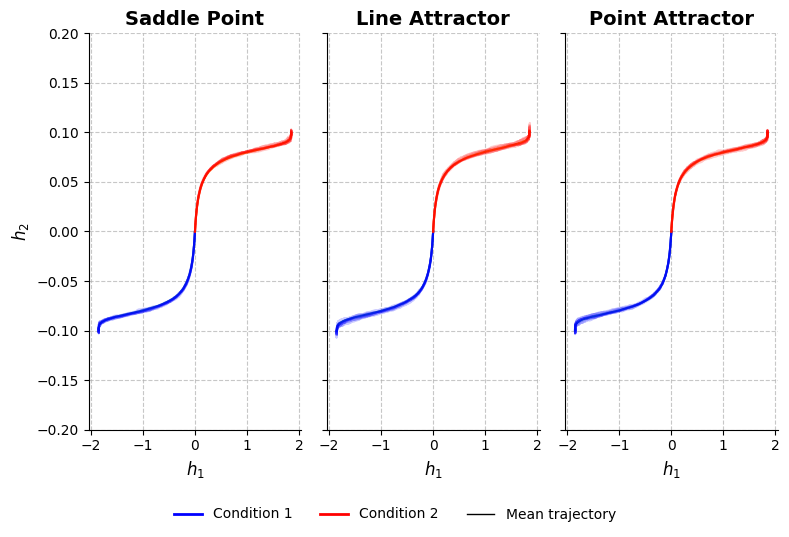

In [1]:
from koopstd.datasets import PDMAttractors

pdm = PDMAttractors(n_samples=5, n_trials=100, sigma=0.05, simul_step=10, dt=0.001)
pdm.visualization()